<a href="https://colab.research.google.com/github/Avinashshah099/Forecasting-with-machine-learing/blob/master/Forecasting_with_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting with machine learning

# Setup

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


In [0]:
def plot_series(time, series, format="_", start=0, end=None, label= None):
  plt.plot(time[start:end],series[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Value")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

def trend(time,slope=0):
  return slope*time

def seasonal_pattern(season_time):
  return np.where(season_time < 0.4,
                  np.cos(season_time*2*np.pi),
                  1/np.exp(3*season_time))
  
def seasonality(time,period,amplitude=1, phase=0):
  season_time=((time+phase)%period)/period
  return amplitude*seasonal_pattern(season_time)

def white_noise(time,noise_level=1,seed=None):
  rnd=np.random.RandomState(seed)
  return rnd.randn(len(time))*noise_level

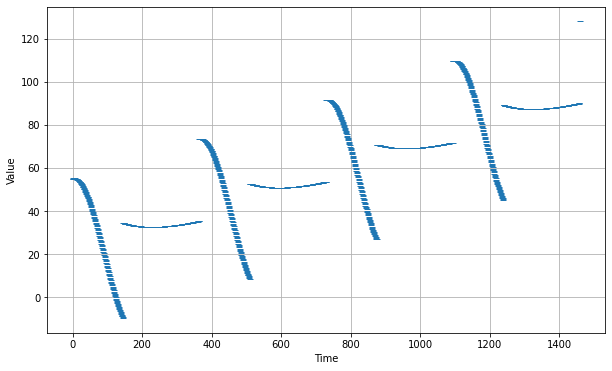

In [30]:
time=np.arange(4*365+1)

slope=0.05
baseline=10
amplitude=40
series=baseline+trend(time,slope)+seasonality(time,period=365,amplitude=amplitude)

noise_level=5
noise = white_noise(time,noise_level, seed=42)

series+=noise_level

plt.figure(figsize=(10,6))
plot_series(time,series)
plt.show()

# Forecasting with Machine Learning

we will train a model to forecast the next step given the previous 30 steps, therefore, we need to create a dataset of 30-step windows for training.

In [0]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [0]:
split_time=1000
time_train=time[:split_time]
x_train= series[:split_time]
time_valid=time[split_time:]
x_valid=series[split_time:]

#Linear Model

In [33]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size=30
train_set=window_dataset(x_train,window_size)
valid_set=window_dataset(x_valid,window_size)

model=tf.keras.models.Sequential([tf.keras.layers.Dense(1,input_shape=[window_size])])
optimizer=tf.keras.optimizers.SGD(lr=1e-5,momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.fit(train_set, epochs=100,validation_data=valid_set)

Epoch 1/100
31/31 [==============================] - 0s 6ms/step - loss: 48.4149 - mae: 49.4576 - val_loss: 27.3558 - val_mae: 27.8308
Epoch 2/100
31/31 [==============================] - 0s 4ms/step - loss: 8.1143 - mae: 8.7262 - val_loss: 6.0133 - val_mae: 6.4036
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 5.1285 - mae: 5.6469 - val_loss: 5.0448 - val_mae: 5.2993
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 4.8750 - mae: 5.3829 - val_loss: 4.8608 - val_mae: 5.2345
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 4.5636 - mae: 5.0936 - val_loss: 4.2667 - val_mae: 4.6812
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 4.4992 - mae: 4.8484 - val_loss: 4.0136 - val_mae: 4.4138
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 4.1708 - mae: 4.6741 - val_loss: 3.9831 - val_mae: 4.4734
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 4.0121

In [35]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size=30
train_set=window_dataset(x_train,window_size)

model=tf.keras.models.Sequential([tf.keras.layers.Dense(1, input_shape = [window_size])])

lr_schedule=tf.keras.callbacks.LearningRateScheduler(
    lambda epoch:1e-6*10**(epoch/30))
optimizer=tf.keras.optimizers.SGD(lr=1e-6,momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), #Huber loss is a loss function used in robust regression, that is less sensitive to outliers in data than the squared error loss.
              optimizer=optimizer,
              metrics=["mae"])
history=model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 2ms/step - loss: 74.7378 - mae: 75.0659 - lr: 1.0000e-06
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 55.4549 - mae: 56.0247 - lr: 1.0798e-06
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 33.3114 - mae: 33.9914 - lr: 1.1659e-06
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 12.0636 - mae: 12.7819 - lr: 1.2589e-06
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 4.1443 - mae: 4.6443 - lr: 1.3594e-06
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 3.9778 - mae: 4.2716 - lr: 1.4678e-06
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 3.7140 - mae: 4.1730 - lr: 1.5849e-06
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 3.6780 - mae: 4.0549 - lr: 1.7113e-06
Epoch 9/100
31/31 [==============================] - 0s 1ms/step - loss: 3.6557 - mae: 3.9906 - lr: 1.84

(1e-06, 0.001, 0.0, 20.0)

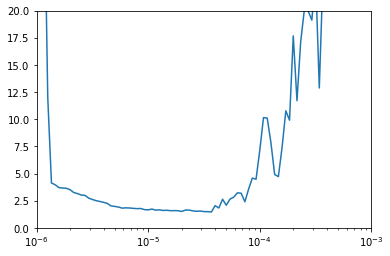

In [36]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

In [38]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 0s 6ms/step - loss: 48.4149 - mae: 49.4576 - val_loss: 27.3558 - val_mae: 27.8308
Epoch 2/500
31/31 [==============================] - 0s 4ms/step - loss: 8.1143 - mae: 8.7262 - val_loss: 6.0133 - val_mae: 6.4036
Epoch 3/500
31/31 [==============================] - 0s 5ms/step - loss: 5.1285 - mae: 5.6469 - val_loss: 5.0448 - val_mae: 5.2993
Epoch 4/500
31/31 [==============================] - 0s 5ms/step - loss: 4.8750 - mae: 5.3829 - val_loss: 4.8608 - val_mae: 5.2345
Epoch 5/500
31/31 [==============================] - 0s 4ms/step - loss: 4.5636 - mae: 5.0936 - val_loss: 4.2667 - val_mae: 4.6812
Epoch 6/500
31/31 [==============================] - 0s 4ms/step - loss: 4.4992 - mae: 4.8484 - val_loss: 4.0136 - val_mae: 4.4138
Epoch 7/500
31/31 [==============================] - 0s 5ms/step - loss: 4.1708 - mae: 4.6741 - val_loss: 3.9831 - val_mae: 4.4734
Epoch 8/500
31/31 [==============================] - 0s 5ms/step - loss: 4.0121

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
lin_forecast= model_forecast(model,series[split_time-window_size:-1], window_size)[:,0]

In [41]:
lin_forecast.shape

(461,)

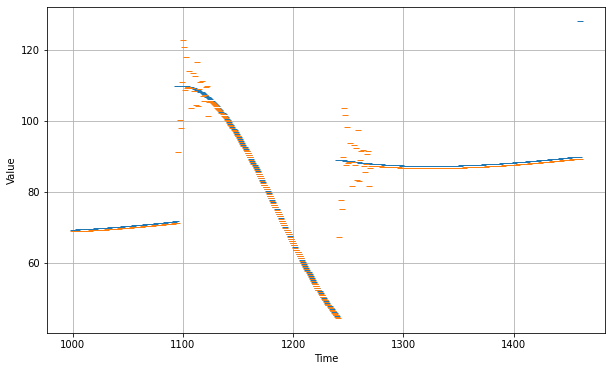

In [43]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [46]:
tf.keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

1.2765843

#Dense Model Forcasting


In [47]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 3ms/step - loss: 49.0381 - mae: 49.2023 - lr: 1.0000e-07
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 45.6599 - mae: 46.0750 - lr: 1.1220e-07
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 41.7612 - mae: 42.2379 - lr: 1.2589e-07
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 37.2959 - mae: 37.9110 - lr: 1.4125e-07
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 32.4987 - mae: 33.0424 - lr: 1.5849e-07
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 27.1032 - mae: 27.5633 - lr: 1.7783e-07
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 21.1289 - mae: 21.6868 - lr: 1.9953e-07
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 14.6234 - mae: 15.2203 - lr: 2.2387e-07
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 7.9486 - mae: 8.4389 - 

(1e-07, 0.005, 0.0, 30.0)

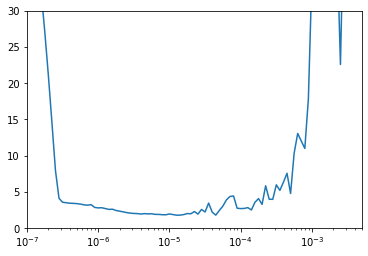

In [48]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 5e-3, 0, 30])

In [49]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 0s 6ms/step - loss: 19.9379 - mae: 20.6724 - val_loss: 7.3692 - val_mae: 7.8921
Epoch 2/500
31/31 [==============================] - 0s 5ms/step - loss: 6.3507 - mae: 6.9312 - val_loss: 4.8294 - val_mae: 4.9870
Epoch 3/500
31/31 [==============================] - 0s 4ms/step - loss: 5.2122 - mae: 5.7238 - val_loss: 4.7536 - val_mae: 5.0640
Epoch 4/500
31/31 [==============================] - 0s 4ms/step - loss: 4.6974 - mae: 5.1977 - val_loss: 3.8362 - val_mae: 4.2937
Epoch 5/500
31/31 [==============================] - 0s 4ms/step - loss: 4.2731 - mae: 4.7650 - val_loss: 3.3655 - val_mae: 3.8530
Epoch 6/500
31/31 [==============================] - 0s 4ms/step - loss: 3.8772 - mae: 4.2961 - val_loss: 2.9974 - val_mae: 3.4884
Epoch 7/500
31/31 [==============================] - 0s 5ms/step - loss: 3.4202 - mae: 3.8772 - val_loss: 2.4895 - val_mae: 3.0342
Epoch 8/500
31/31 [==============================] - 0s 5ms/step - loss: 3.0153 -

In [0]:
dense_forecast= model_forecast(
    model,
    series[split_time-window_size:-1],
    window_size)[:,0]

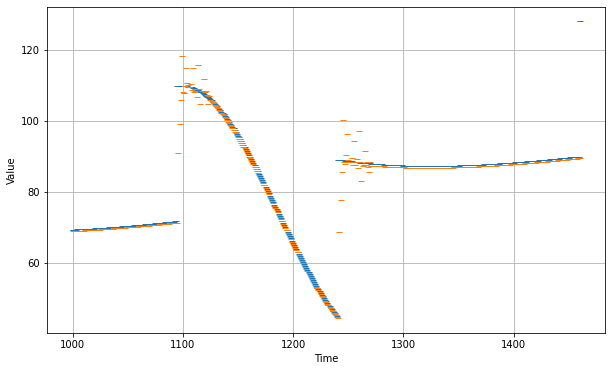

In [52]:
plt.figure(figsize=(10,6))
plot_series(time_valid,x_valid)
plot_series(time_valid,dense_forecast)

In [53]:
tf.keras.metrics.mean_absolute_error(x_valid,dense_forecast).numpy()

1.014498